

```
# This is formatted as code
```



In [2]:
import os
import warnings
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math

from sklearn.model_selection import train_test_split

# for grayscale conversion of numpy picture array
from skimage import color

# for exploring filters of a CNN
from scipy.signal import convolve2d

# for the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn

# for making a model using tensorflow
import tensorflow as tf
from keras.datasets import cifar10
from keras import Sequential, layers, callbacks
from keras.losses import SparseCategoricalCrossentropy
from keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!unzip /content/gdrive/MyDrive/DeepFake_Detection/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: faces_224/yppwksjuui.jpg  
  inflating: faces_224/yppybofyww.jpg  
  inflating: faces_224/ypqjxdwawy.jpg  
  inflating: faces_224/ypqsxalhkw.jpg  
  inflating: faces_224/ypqxbbydxe.jpg  
  inflating: faces_224/ypqzrivawi.jpg  
  inflating: faces_224/yprdarrkit.jpg  
  inflating: faces_224/yprhthcacq.jpg  
  inflating: faces_224/yprmkhffdi.jpg  
  inflating: faces_224/yprnmqkhga.jpg  
  inflating: faces_224/yprqkgcoid.jpg  
  inflating: faces_224/yprsoygtjn.jpg  
  inflating: faces_224/yprxcbpmaj.jpg  
  inflating: faces_224/yprxtgidkk.jpg  
  inflating: faces_224/ypsbicsrsf.jpg  
  inflating: faces_224/ypsfvpanpn.jpg  
  inflating: faces_224/ypsgzbgbaz.jpg  
  inflating: faces_224/ypskfnxajx.jpg  
  inflating: faces_224/ypskxfumwo.jpg  
  inflating: faces_224/ypslvqfsrd.jpg  
  inflating: faces_224/ypsmruzzyt.jpg  
  inflating: faces_224/ypsqgodnrn.jpg  
  inflating: faces_224/ypsydrqqsl.jpg  
  inflating: faces_224/yptcha

In [6]:
df = pd.read_csv('metadata.csv')

In [7]:
df.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [8]:
import cv2

len(df[df.label=='FAKE']),len(df[df.label=='REAL'])
real_df = df[df["label"] == "REAL"]
fake_df = df[df["label"] == "FAKE"]

#question: should the real and fake training sets be equal size? as is the training set has a lot more fake pictures
real_df = real_df.sample(5000, random_state=42)
fake_df = fake_df.sample(5000, random_state=42)
sample_data = pd.concat([real_df, fake_df])

# train_set, test_set = train_test_split(sample_data,test_size=0.5,random_state=42,stratify=sample_data['label'])
train_set, test_set = train_test_split(sample_data,test_size=0.2,random_state=42,stratify=sample_data['label'])

def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        var = (cv2.imread(os.path.join('/content/faces_224/', img[:-4] + '.jpg')))
        images.append(var)
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)

    return np.array(images),np.array(labels)

x_train,y_train=retreive_dataset(train_set)
print(x_train[0])
print(train_set.shape)




[[[ 7  6 10]
  [ 7  6 10]
  [ 7  6 10]
  ...
  [10  5  6]
  [11  5  6]
  [11  5  6]]

 [[ 7  6 10]
  [ 7  6 10]
  [ 7  6 10]
  ...
  [10  5  6]
  [11  5  6]
  [11  5  6]]

 [[ 7  6 10]
  [ 7  6 10]
  [ 7  6 10]
  ...
  [10  5  6]
  [11  5  6]
  [11  5  6]]

 ...

 [[21 29 29]
  [20 28 28]
  [18 26 26]
  ...
  [14 13 15]
  [14 13 15]
  [14 13 15]]

 [[20 28 28]
  [19 27 27]
  [17 25 25]
  ...
  [13 12 14]
  [13 12 14]
  [13 12 14]]

 [[20 28 28]
  [19 27 27]
  [17 25 25]
  ...
  [12 11 13]
  [13 12 14]
  [13 12 14]]]
(8000, 5)


In [9]:
gray_training = []
def gray_scale(set_name):
  for img in set_name:
    gray_scaled = tf.image.rgb_to_grayscale(img)
    gray_training.append(gray_scaled)
gray_scale(x_train)


1


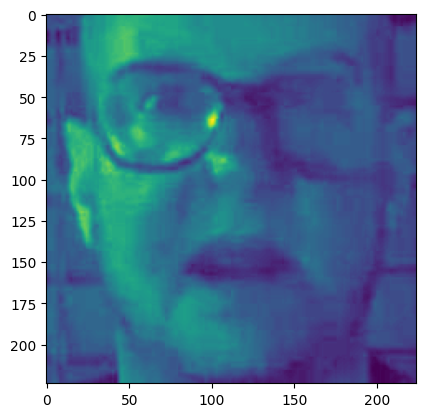

In [10]:
plt.imshow(gray_training[102])
print(y_train[102])

In [11]:
# Filters

sobel_filter = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])

gaussian_filter = np.array([[1, 2, 1],
                           [2, 4, 2],
                           [1, 2, 1]]) / 16

identity_filter = np.array([[0, 0, 0],
                           [0, 1, 0],
                           [0, 0, 0]])

emboss_filter = np.array([[-2, -1, 0],
                          [-1, 1, 1],
                          [0, 1, 2]])

box_filter = np.array([[1, 1, 1],
                       [1, 1, 1],
                       [1, 1, 1]]) / 9

custom_filter = np.array([[0, 0, 0],
                          [1, 1, 1],
                          [1, 1, 1]])

filter_names = ['sobel', 'gaussian', 'identity',
                'emboss', 'box', 'custom']

filter_set = [sobel_filter, gaussian_filter, identity_filter,
           emboss_filter, box_filter, custom_filter]

In [12]:

# OLD MODEL:
# model = Sequential([
#     layers.Rescaling(scale=1./255, input_shape=(224, 224, 3)),
#     layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
#     layers.Conv2D(filters=75, kernel_size=3, activation='relu', padding='same'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),
#     layers.Dropout(0.2),
#     layers.Conv2D(filters=75, kernel_size=3, activation='relu', padding='same'),
#     layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),
#     layers.Dropout(0.2),
#     layers.BatchNormalization(),
#     layers.Flatten(),
#     layers.Dense(units=512, activation='relu'),
#     layers.Dense(units=1, activation='sigmoid')
# ])

model = Sequential([
    layers.Rescaling(scale=1./255, input_shape=(224,224,3)),
    layers.Conv2D(filters=32, kernel_size=7),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Conv2D(filters=64,  kernel_size=7),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Conv2D(filters=128,  kernel_size=7),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(units=128, activation="relu",
                 kernel_initializer="he_normal"),
     layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=64, activation="relu",
                 kernel_initializer="he_normal"),
    layers.Dropout(0.2),
    layers.Dense(units=1, activation="sigmoid")
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 218, 218, 32)      4736      
                                                                 
 max_pooling2d (MaxPooling2  (None, 109, 109, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 109, 109, 32)      128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 109, 109, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 103, 103, 64)      1

In [13]:
# creating and training the CNN
train_set = np.asarray(train_set)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(x_train, y_train,
                    shuffle=True,
                    batch_size=16,
                    # epochs=50,
                    epochs = 12,
                    verbose=1,
                    callbacks = callback)

Epoch 1/12
500/500 [==============================] - 41s 63ms/step - loss: 0.7542 - accuracy: 0.5163
Epoch 2/12
500/500 [==============================] - 32s 65ms/step - loss: 0.7079 - accuracy: 0.5224
Epoch 3/12
500/500 [==============================] - 32s 64ms/step - loss: 0.6941 - accuracy: 0.5401
Epoch 4/12
500/500 [==============================] - 33s 65ms/step - loss: 0.6866 - accuracy: 0.5536
Epoch 5/12
500/500 [==============================] - 33s 65ms/step - loss: 0.6829 - accuracy: 0.5633
Epoch 6/12
500/500 [==============================] - 33s 65ms/step - loss: 0.6913 - accuracy: 0.5322
Epoch 7/12
500/500 [==============================] - 33s 66ms/step - loss: 0.6800 - accuracy: 0.5671
Epoch 8/12
500/500 [==============================] - 33s 66ms/step - loss: 0.6698 - accuracy: 0.5869
Epoch 9/12
500/500 [==============================] - 33s 66ms/step - loss: 0.6765 - accuracy: 0.5742
Epoch 10/12
500/500 [==============================] - 33s 66ms/step - loss: 0.664

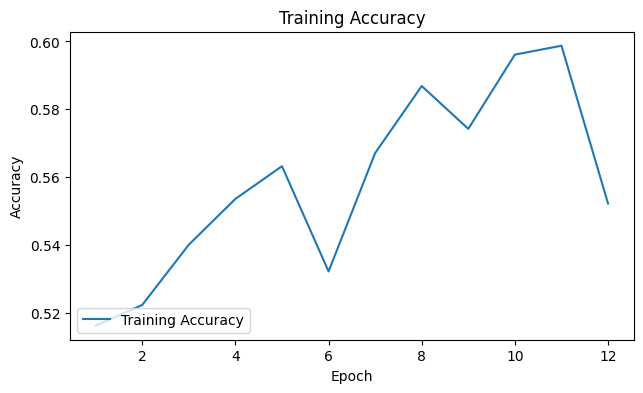

In [14]:
accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.title('Training Accuracy')
plt.show()

In [15]:
from sklearn.metrics import accuracy_score

x_test,y_test=retreive_dataset(test_set)

y_pred = model.predict(x_test)
y_test_pred_binary = (y_pred > 0.5).astype(int)

y_train_pred = model.predict(x_train)
y_train_pred_binary = (y_train_pred > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred_binary)
train_accuracy = accuracy_score(y_train, y_train_pred_binary)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

250/250 [==============================] - 6s 22ms/step
Test Accuracy: 59.30%
Training Accuracy: 59.08%
